In [1]:
import numpy as np
try:
    from IPython.core.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False
import sys
import datetime
%matplotlib inline
import matplotlib.pyplot as plt

def plotCurve(train_mean, train_std,test_mean,test_std,sizes):
    plt.plot(sizes, train_mean, 
            color='blue', marker='o', 
            markersize=5, 
            label='training accuracy')
    plt.fill_between(sizes, 
                  train_mean + train_std,
                   train_mean - train_std, alpha=0.15, color='blue')

    plt.plot(sizes, test_mean, 
              color='green', linestyle='--', 
              marker='s', markersize=5, 
             label='validation accuracy')
    plt.fill_between(sizes, 
                      test_mean + test_std,
                     test_mean - test_std, 
                    alpha=0.15, color='green')
    plt.xlabel('x_range')
    plt.ylabel('Accuracy')
    plt.show()
def likehoodScore(proba,y):
    return np.sum(proba * y)/proba.shape[0]

def firstNScore(n, pred, y):
    backup = np.array(pred, copy =True)
    for r in range(pred.shape[0]):
        row = backup[r]
        s = np.sort(row)
        for c in range(pred.shape[1]):
            temp = backup[r][c]
            backup[r][c] = False
            for j in range(1,n+1):
                if temp == s[-j]:
                    backup[r][c] = True
                    break
    res = np.sum(np.logical_and(backup,y))/pred.shape[0]
    return res               

def oneHotDecode(self, X_sample):
    result=None
    fiPos = 0
    colIndex = 0
    while colIndex < X_sample.shape[1]:
        if fiPos < len(self.ohe.n_values_) and colIndex == self.ohe.feature_indices_[fiPos]:                
            start = self.ohe.feature_indices_[fiPos]
            end_ = start+ self.ohe.n_values_[fiPos]
            #print("start{} end{}".format(start,end_))
            classes = np.argmax(X_sample[:,start:end_],axis=1).reshape(X_sample.shape[0],1)
            if result is None:
                result = classes
            else:
                result=np.hstack([result,classes])
            colIndex = end_
            fiPos = fiPos +1
        else:
            if result is None:
                result = X_sample[:,colIndex:colIndex+1]
            else:
                result=np.hstack([result, X_sample[:,colIndex:colIndex+1]])
            colIndex = colIndex +1
        
    return result 
def convertToDate(dayStamps):
    res = [] 
    for v in dayStamps:
        res.append(datetime.datetime.fromtimestamp(float(v)*24*60*60))
    return res


    

def precisionMatrix(proba, y):
    def _precisionClassify(df,proba, wins, c =0 ):
        for indx, v in enumerate(proba):
            row = 0
            col = 0
            if wins[indx] == c:
                col = 0
            else:
                col =1
            if v <0.2:
                row =6 
            elif v < 0.3 and  v >=0.2:
                row =5 
            elif v < 0.4 and v >= 0.3:
                row = 4 
            elif v < 0.5 and v >= 0.4:
                row = 3 
            elif v < 0.6 and v >= 0.5:
                row = 2 
            elif v < 0.8 and v >= 0.6:
                row = 1
            df.iloc[row,col] = df.iloc[row,col]+1 
        df[df.columns[2]] = df[df.columns[0]] /(df[df.columns[1]] + df[df.columns[0]])
        return df
    rowHeader = ['>80','60-80','50-60','40-50','30-40','20-30','<20']
    df = pd.DataFrame(np.zeros(shape=(7,3)),index=rowHeader, columns=['h_Correct', 'h_Wrong','h_Precent'])
    hproba = proba[:,0]
    wins = np.argmax(y,axis=1)
    df = _precisionClassify(df,hproba,wins)
    temp = pd.DataFrame(np.zeros(shape=(7,3)),index=rowHeader, columns=['d_Correct', 'd_Wrong','d_Precent'])
    dproba = proba[:,1]
    df = df.join(_precisionClassify(temp,dproba,wins,c=1))
    temp = pd.DataFrame(np.zeros(shape=(7,3)),index=rowHeader, columns=['a_Correct', 'a_Wrong','a_Precent'])
    aproba = proba[:,2]
    df = df.join(_precisionClassify(temp,aproba,wins,c=2))
    
    bound = pd.DataFrame(np.array([[0.8,1.0],[0.6,0.8],[0.5,0.6],[0.4,0.5],[0.3,0.4],[0.2,0.3],[0,0.2]] )
                                ,index=rowHeader, columns=['[lower', 'upper)'])
            
    return bound.join(df)
       
from datetime import date, timedelta
from sklearn.metrics import precision_score


def futureTest(mlp, X,y,numOfWeek = 10,verbose=False):
    decoded = oneHotDecode(c, X)
    dates = convertToDate(X[:,c.dateColumn])
    dates = [d - timedelta(days=2) for d in dates]    
    weeks  = [ v.isocalendar()[1] for v in dates]
    thisWeek = weeks[-1]
    start = -1
    last = X.shape[0]
    index = -1
    w = 0
    sum_proba =None 
    sum_y =None
    sum_train_proba=None
    sum_train_y=None
    while w < numOfWeek:
        if thisWeek != weeks[index]:
            start = X.shape[0] +index+1
            X_train = X[0:start, :]
            X_test = X[start:last,:]
            y_train = y[0:start,:]
            y_test = y[start:last,:]
            mlp.fit(X_train,y_train)
            decoded = oneHotDecode(c,X_test)
            home = np.array([c.inverseTeamMapping(decoded[:,0])]).reshape(X_test.shape[0],1)
            away = np.array([c.inverseTeamMapping(decoded[:,1])]).reshape(X_test.shape[0],1)
            stack = np.hstack([home,away])
            proba = mlp.predict_proba(X_test)
            train_proba =mlp.predict_proba(X_train)
            errorIndx = np.argmax(proba,axis=1) != np.argmax(y_test,axis=1)
            if sum_proba is None:
                sum_proba = proba
                sum_y = y_test
                sum_train_proba = train_proba
                sum_train_y = y_train
            else:
                sum_proba = np.vstack([sum_proba,proba])
                sum_y = np.vstack([sum_y,y_test])
                sum_train_proba = np.vstack([sum_train_proba, train_proba])
                sum_train_y= np.vstack([sum_train_y, y_train])
            if verbose == True:
                print("week{}".format(w))
                print("numOftest {} , score {}".format(X_test.shape[0],mlp.score(X_test,y_test)))
                print(np.hstack([stack[errorIndx],proba[errorIndx],y_test[errorIndx]]))
                print("first2 : {}",firstNScore(2,proba,y_test))
            last = start
            thisWeek = weeks[index]
            w = w+1
        index = index -1
        
    print("summary")
    print("score:")
    score = firstNScore(1,sum_proba,sum_y)
    print(score)
    print("2like")
    like2 = firstNScore(2,sum_proba,sum_y)
    print(precisionMatrix(sum_proba,sum_y))
    y_true= np.argmax(sum_y,axis=1)
    y_pred = np.argmax(sum_proba,axis=1)
    print("sum precision:{}".format(precision_score(y_true,y_pred,average=None)))
    return firstNScore(1,sum_train_proba,sum_train_y), score, like2


In [2]:
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
class FootballDataHelper:
    def __init__ (self, recentNum=5):
        self.win_mapping = {'H':0, 'D':1,'A':2}
        self.recentNum = recentNum
        self.df = None
        self.teamsData={}
        self.session = 0
        self.generalList =['HS','AS','HST','AST','H_poss' ,'A_poss' ,'H_atk_3rd', 'A_atk_3rd',
 'H_atk_3rd_tot', 'A_atk_3rd_tot','H_red_goal' ,'A_red_goal' ,'H_red_on',
 'A_red_on' ,'H_red_tot' ,'A_red_tot' ,'H_chance_goal' ,'A_chance_goal',
 'H_chance_tot', 'A_chance_tot' ,'H_successful_tackle', 'A_successful_tackle',
 'H_tackle_tot', 'A_tackle_tot', 'H_successful_clearance',
 'A_successful_clearance', 'H_clearance_tot' ,'A_clearance_tot',
 'H_interceptions' ,'A_interceptions', 'H_blocks', 'A_blocks']
        self.percentList = ['atk_3rd','atk_3rd_tot','red_goal','red_tot','red_on','red_tot',
                           'chance_goal','chance_tot','successful_tackle','tackle_tot',
                            'successful_clearance','clearance_tot']
       
    def addColumns(self,df, addition):    
        dates = df["Date"].drop_duplicates().values
        col_adds = []
        for colAdd in addition.columns:
             if colAdd not in df.columns:
                    df[colAdd]=np.zeros(shape=(df.shape[0],))
                    col_adds.append(colAdd)
        for date in dates:
            dateAddition= addition[addition['Date'] == date].sort(columns='HomeTeam')
            dateDf  = df [df['Date']==date].sort(columns='HomeTeam')
            for col in col_adds:
                dateDf[col] = dateAddition[col].values
            df.update(dateDf)
        return df
            
    def saveDf(self,filename):
        self.df.to_csv(filename,index=False)
    def loadDf(self,filename):
        df = pd.read_csv(filename)
        df['Date'] = pd.to_datetime(df['Date'])    
        self.df = df
        teams = self.df['HomeTeam'].drop_duplicates()
        teamMap = {}
        for index , v in enumerate(teams):
            teamMap[v] = index
        self.teamsMap = teamMap
        referees = self.df['Referee'].drop_duplicates()
        refereesMap = {}
        for index , v in enumerate(referees):
            refereesMap[v] = index+1

        self.refereesMap = refereesMap
    def readFootBallData(self,year): 
        filename = "dataSet/E{}.csv".format(year)
        df = pd.read_csv(filename)
        #df = df.drop(df.columns[range(23,df.shape[1])], axis=1)
        #df = df.drop("Div",axis=1)
        df['Date'] = pd.to_datetime(df['Date'])
        df['session'] = pd.Series(np.ones(shape=(df.shape[0],))*self.session, index=df.index)
        self.session = self.session +1
        
        matchDetail = pd.read_csv("dataSet/match{}.csv".format(year))
        matchDetail['Date'] =pd.to_datetime(matchDetail['Date'])
        df = self.addColumns(df,matchDetail)
        
        df["Future"] = np.zeros(shape=(df.shape[0],))
        
        if self.df is None:
            self.df = df
        else:
            self.df = pd.concat([self.df,df])
            
        self.df = self.df.reset_index(drop=True)
        teams = self.df['HomeTeam'].drop_duplicates()
        teamMap = {}
        for index , v in enumerate(teams):
            teamMap[v] = index
        self.teamsMap = teamMap
        referees = self.df['Referee'].drop_duplicates()
        refereesMap = {}
        for index , v in enumerate(referees):
            refereesMap[v] = index+1

        self.refereesMap = refereesMap
    def readFuture(self):
        filename = "dataSet/future.csv"
        df = pd.read_csv(filename)
        #df = df.drop(df.columns[range(23,df.shape[1])], axis=1)
        #df = df.drop("Div",axis=1)
        df['Date'] = pd.to_datetime(df['Date'])
        df["Future"] = np.ones(shape=(df.shape[0],))
        if self.df is None:
            self.df = df
        else:
            self.df = pd.concat([self.df,df])
            
        self.df['HTR']=self.df['HTR'].fillna('D')
        self.df = self.df.fillna(0)
        self.df = self.df.reset_index(drop=True)
        teams = self.df['HomeTeam'].drop_duplicates()
        teamMap = {}
        for index , v in enumerate(teams):
            teamMap[v] = index
        self.teamsMap = teamMap
        referees = self.df['Referee'].drop_duplicates()
        refereesMap = {}
        for index , v in enumerate(referees):
            refereesMap[v] = index+1

        self.refereesMap = refereesMap
        
    def getTeam(self,dataFrame, teamName):       
        return dataFrame[(dataFrame["HomeTeam"] == teamName) | (dataFrame["AwayTeam"] == teamName)]
 
        
    def previousRecords(self,team, date , recentNum):
        prev = team[( team["Date"] < date)]
        
        if prev.shape[0] < recentNum :
            #print("less than min Num")
            return None
        else:
            return prev.iloc[-recentNum:]
    def readPredict (self, filename):
        df = pd.read_csv(filename)
        df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)

        return df
    
    
  
    def inverseTeamMapping (self, col):
        inverseMap ={}
        for name in self.teamsMap.keys():        
            inverseMap[self.teamsMap[name]] = name
        res =[]
        for idex, v in enumerate(col):
            res.append(inverseMap[v])
        return res


    def readTeamMatch(self, teamName):
        df = pd.read_csv('teams/'+teamName+'.csv')
        df['1'] = pd.to_datetime(df['1'],yearfirst=True)
        #df['1']= (pd.to_numeric(df['1'])/1e9/24/60/60)
        self.teamsData[teamName]=df.sort(['1'],ascending=[False])
        self.teamsById[self.teamsMap[teamName]]=self.teamsData[teamName]
    
    def commonMapping(self, X):
        X['HomeTeam'] = X['HomeTeam'].map(self.teamsMap)
        X['AwayTeam'] = X['AwayTeam'].map(self.teamsMap)
        X['Referee']=X['Referee'].map(self.refereesMap).fillna(0)
        X['HTR'] = X['HTR'].map(self.win_mapping)
        X['FTR'] = X['FTR'].map(self.win_mapping)
        return X
    def initData(self, X, target,encode):
        X  = X.sort_values(by="Date")
        isInput = False
        if target is None:
            target =X      
        else:
            if self.ohe is None:
                raise Exception("Not yet get train data")
            isInput = True
            if encode == True:
                target = self.commonMapping(target)
        y=None
        if encode == True:    
            X =self.commonMapping(X)
            y = []
            for v in target['FTR']:
                y.append(range(3)==v)
        else:
            y = target['FTR'].values
        target_date = (pd.to_numeric(target['Date'])/1e9/24/60/60).values
        return isInput, X,y, target, target_date
   
    def aggregate(self,recents,nonExpand,isInput,encode):
        res =None
        if encode == True:
            if isInput==False:
                self.ohe = OneHotEncoder(categorical_features='all')
                self.ohe.fit(recents)
            res = self.ohe.transform(recents).toarray()
        else:
            res = np.array(recents)
        self.dateColumn = res.shape[1]
        res = np.hstack([res,nonExpand])
        return res
  
    def getH7(self,removeInsufficient=True, target=None,encode = True,future =0):
        #Simple recent win,draw, lose 
        df = self.df
        if removeInsufficient == True:
            df= df[df['Sufficient'] == 1]
        df=df[df['Future']==future]
        
        isInput, X, y,target, target_date = self.initData(df,target,encode)
        resy=[]
        resx=[]
        print("start format")
        recents = X[['HomeTeam','AwayTeam','Referee']].values
        haccp = X['HAccP'].values.reshape(X.shape[0],1)
        aaccp = X['AAccP'].values.reshape(X.shape[0],1)
        homeRecent = np.hstack([X[['HWin','HDraw','HLose']].values,
                                (X['HScore'].values - X['HConcede'].values).reshape(X.shape[0],1)])
        awayRecent = np.hstack([X[['AWin','ADraw','ALose']].values,
                                (X['AScore'].values - X['AConcede'].values).reshape(X.shape[0],1)])
        homeMoral = X['HMoral'].values.reshape(X.shape[0],1)
        awayMoral = X['AMoral'].values.reshape(X.shape[0],1)
        target_date = target_date.reshape(X.shape[0],1)
        
        
        
        
        acc_headers = [e+'_Acc' for e in self.generalList]
        self.acc_headers= acc_headers
        general = X[['HRestDay','ARestDay']+acc_headers].values
        
        ha_headers =np.array(acc_headers).reshape(len(acc_headers)/2, 2).T
        print(ha_headers)
        h_over_a = (X[ha_headers[0,:]].values/X[ha_headers[1,:]].values)
        self.ha_headers = [ ha_headers[0,i]+'/'+ha_headers[1,i] for i in range(ha_headers.shape[1])]
        
        percent_headers =[]
        percent_headers += ['H_'+e+'_Acc' for e in self.percentList]
        percent_headers += ['A_'+e+'_Acc' for e in self.percentList]
        n_percent_headers = np.array(percent_headers).reshape(len(percent_headers)/2, 2).T
        percent_values = (X[n_percent_headers[0,:]].values/X[n_percent_headers[1,:]].values)
        self.percent_headers = [ n_percent_headers[0,i]+'/'+n_percent_headers[1,i] for i in range(n_percent_headers.shape[1])]
        
        nonExpand =np.hstack([target_date,haccp-aaccp,(haccp+1)/(aaccp+1),
                            homeRecent,awayRecent, 
                              homeMoral - awayMoral + haccp - aaccp, X[['H_Enemy_Acc','A_Enemy_Acc']].values,
                              general, percent_values
                             ])
        res = self.aggregate(recents,nonExpand,future,encode)
        print("finish")
        sys.stdout.flush()
        return res, np.array(y)
    def _getRank(self,x, X,teamName,recentNum):
        team = self.getTeam(X,teamName)
        prev = team[team['Date'] < x['Date']].values      
        for i in range(recentNum):
            pass
    def initRanking(self, n = 20):
        defaultPt = 1
        df = self.df.sort(columns=["Date"],ascending=[False])
        df["HPoints"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["APoints"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["HAccP"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["AAccP"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        hpoints= df["HPoints"].values
        apoints=df["APoints"].values
        ftr = df["FTR"].values
        for i in range(df.shape[0]):
            sys.stdout.write("\r progress {}".format(i))
            sys.stdout.flush()
            if ftr[i] == 'H':
                hpoints[i] = 3
                apoints[i] = 0
            elif ftr[i] == 'D':
                hpoints[i] = 1
                apoints[i] = 1
            else :
                hpoints[i] = 0
                apoints[i] = 3
        df["HPoints"]=hpoints
        df["APoints"]=apoints
        for teamName in self.teamsMap.keys():
            team  = df[(df['HomeTeam']==teamName) | (df['AwayTeam'] == teamName)] 
            hometeam = team['HomeTeam'].values
            hpoints = team['HPoints'].values
            apoints = team['APoints'].values
            psum = 0
            haccp = team['HAccP'].values
            aaccp = team['AAccP'].values
        
            for  i in range(0,n):
                if i < hpoints.shape[0]:
                    psum = psum + (hpoints[i] if hometeam[i] == teamName else apoints[i] ) 
                else:
                    psum = psum + defaultPt        
                    
        
            for j in range(team.shape[0]):

                if j+n < hpoints.shape[0]:                     
                    psum = psum + (hpoints[j+n] if hometeam[j+n]==teamName else apoints[j+n])
                else:
                    psum = psum + defaultPt 
                
                psum = psum - (hpoints[j] if hometeam[j]==teamName else apoints[j])
                    
                if hometeam[j] == teamName:
                    haccp[j]=psum
                else:
                    aaccp[j]=psum
            team['HAccp']=haccp
            team['AAccP']=aaccp
            #print(team[['HomeTeam','AwayTeam','HAccP','AAccP']])
            df.update(team)
            
            #print(df[['HomeTeam','AwayTeam','HAccP','AAccP']])
        self.df =df
        return df
    def initRecentData(self, n =5):
        df = self.df.sort(columns=["Date"],ascending=[False])
        df["HWin"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["AWin"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["HDraw"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["ADraw"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["HLose"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["ALose"] = pd.Series(np.zeros(shape=(df.shape[0],)))
                
        df["HScore"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["AScore"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["HConcede"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["AConcede"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["HMoral"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["AMoral"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["HRestDay"]= pd.Series(np.zeros(shape=(df.shape[0],)))
        df["ARestDay"]= pd.Series(np.zeros(shape=(df.shape[0],)))
        df["H_Enemy_Acc"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["A_Enemy_Acc"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        #general
        generalList = self.generalList 
        generalOutput = []
        for attr in generalList:
            temp = attr+'_Acc'
            df[temp]=pd.Series(np.zeros(shape=(df.shape[0],)))
            generalOutput.append(temp)
        #
        df["Sufficient"] = pd.Series(np.ones(shape=(df.shape[0],)))
        
      
            
        
        hscore = df['FTHG'].values
        ascore = df['FTAG'].values
        hconcede = df ['FTAG'].values
        aconcede = df['FTHG'].values
               
        hwin = df['HWin'].values
        awin = df['AWin'].values
        hlose = df['HLose'].values
        alose = df['ALose'].values
        hdraw = df['HDraw'].values
        adraw = df['ADraw'].values
        hmoral = df['HMoral'].values
        amoral = df['AMoral'].values
        
        rankRatio = (df['HAccP'].values+1) / (df['AAccP'].values +1)
        
        
        ftr = df["FTR"].values
        for i in range(df.shape[0]):
            sys.stdout.write("\r progress {}".format(i))
            sys.stdout.flush()
            if ftr[i] == 'H':
                hwin[i] = 1
                hmoral[i] = 3 * 1/rankRatio[i]
                alose[i]= 1
                amoral[i] = -3 * 1/rankRatio[i]
            elif ftr[i] == 'D':
                hdraw[i] = 1
                hmoral[i] = 1 * 1/rankRatio[i]
                adraw[i] = 1
                amoral[i] = 1 * rankRatio[i]
            else :
                hlose[i] = 1
                hmoral[i] = -3*rankRatio[i]
                awin [i] = 1
                amoral[i] = 3*rankRatio[i]
        
        
        df["HWin"]=hwin
        df["AWin"]=awin
        df["HDraw"]=hdraw
        df["ADraw"]=adraw
        df["HLose"]=hlose
        df["ALose"]=alose
        df["HScore"]=hscore
        df["AScore"]=ascore
        df["HConcede"]=hconcede
        df["AConcede"]=aconcede
        df["HMoral"] = hmoral
        df["AMoral"] = amoral
        
        
        
        for teamName in self.teamsMap.keys():
            print(teamName)
            team  = df[(df['HomeTeam']==teamName) | (df['AwayTeam'] == teamName)] 
            hometeam = team['HomeTeam'].values
            hwin = team["HWin"].values
            awin = team["AWin"].values
            hlose= team["HLose"].values
            alose = team["ALose"].values
            hdraw = team["HDraw"].values
            adraw = team["ADraw"].values
            hscore = team["HScore"].values
            ascore = team["AScore"].values
            hconcede = team["HConcede"].values
            aconcede = team["AConcede"].values
            hmoral = team["HMoral"].values
            amoral = team["AMoral"].values
            hrestday = team["HRestDay"].values
            arestday = team["ARestDay"].values
            
            haccp = team["HAccP"].values
            aaccp = team["AAccP"].values
            h_enemy = team["H_Enemy_Acc"].values
            a_enemy = team["A_Enemy_Acc"].values
            enemy_sum = 0
            
            #general
            original_list =[]
            output_list=[]
            for indx, o_attr in enumerate(generalList):
                original_list.append(team[o_attr].values)
                output_list.append(team[generalOutput[indx]].values)
            
            
            matchDate =team['Date'].values
            sufficient = team['Sufficient'].values
            teamMatchesDate = self.teamsData[teamName].sort('1',ascending=False)['1'].values
            
            restday = 0
            winsum =0 
            losesum=0
            drawsum=0
            scoresum =0
            concedesum=0
            moralsum = 0
            #print(team[['HomeTeam','AwayTeam','HWin']])
            teamAttrSum_list=[0 for i in range(int(len(original_list)/2))]
            for  i in range(0,n):
                if i < team.shape[0]:
                    scoresum = scoresum + (hscore[i] if hometeam[i] == teamName else ascore[i])
                    winsum = winsum + (hwin[i] if hometeam[i] == teamName else awin[i])
                    losesum= losesum + (hlose[i] if hometeam[i] == teamName else alose[i])
                    drawsum= drawsum + (hdraw[i] if hometeam[i] == teamName else adraw[i])
                    concedesum = concedesum+ (hconcede[i] if hometeam[i] == teamName else aconcede[i])
                    moralsum= moralsum+ (hmoral[i] if hometeam[i] == teamName else amoral[i])
                    enemy_sum += (aaccp[i] if hometeam[i] == teamName else haccp[i])
                    for attrIndx in range(len(teamAttrSum_list)):
                        teamAttrSum_list[attrIndx] +=(original_list[2*attrIndx][i] if hometeam[i] == teamName else original_list[2*attrIndx+1][i])
                else:
                    # + 0
                    pass
            dateIndx = 0
            for j in range(team.shape[0]):
                while True:
                    if dateIndx >= teamMatchesDate.shape[0]:
                        sufficient[j] = False
                        break
                    if teamMatchesDate[dateIndx] < matchDate[j] :
                        restday = (matchDate[j] - teamMatchesDate[dateIndx])/np.timedelta64(1,'D')
                        break
                    else:
                        dateIndx = dateIndx + 1
                
                if j+n < team.shape[0]:                     
                    scoresum = scoresum + (hscore[j+n] if hometeam[j+n] == teamName else ascore[j+n])
                    winsum = winsum + (hwin[j+n] if hometeam[j+n] == teamName else awin[j+n])
                    losesum= losesum + (hlose[j+n] if hometeam[j+n] == teamName else alose[j+n])
                    drawsum= drawsum + (hdraw[j+n] if hometeam[j+n] == teamName else adraw[j+n])
                    concedesum = concedesum+ (hconcede[j+n] if hometeam[j+n] == teamName else aconcede[j+n])
                    moralsum= moralsum+ (hmoral[j+n] if hometeam[j+n] == teamName else amoral[j+n])
                    enemy_sum += (aaccp[j+n] if hometeam[j+n] == teamName else haccp[j+n])
                    for attrIndx in range(len(teamAttrSum_list)):
                        teamAttrSum_list[attrIndx] += (original_list[2*attrIndx][j+n] if hometeam[j+n] == teamName else original_list[2*attrIndx+1][j+n])
                else:
                    sufficient[j] = False
                    
                
                scoresum = scoresum - (hscore[j] if hometeam[j] == teamName else ascore[j])
                winsum = winsum - (hwin[j] if hometeam[j] == teamName else awin[j])
                losesum= losesum - (hlose[j] if hometeam[j] == teamName else alose[j])
                drawsum= drawsum - (hdraw[j] if hometeam[j] == teamName else adraw[j])
                concedesum = concedesum - (hconcede[j] if hometeam[j] == teamName else aconcede[j])
                moralsum= moralsum - (hmoral[j] if hometeam[j] == teamName else amoral[j])
                enemy_sum -= (aaccp[j] if hometeam[j] == teamName else haccp[j])
                for attrIndx in range(len(teamAttrSum_list)):
                    teamAttrSum_list[attrIndx] -=  (original_list[2*attrIndx][j] if hometeam[j] == teamName else original_list[2*attrIndx+1][j])
                    
                if hometeam[j] == teamName:
                    hscore[j] = scoresum
                    hwin[j] = winsum
                    hlose[j] = losesum
                    hdraw[j] = drawsum
                    hconcede[j] = concedesum
                    hmoral[j] = moralsum
                    hrestday[j] = restday
                    h_enemy[j] = enemy_sum
                    for attrIndx in range(len(teamAttrSum_list)):
                        output_list[2*attrIndx][j] = teamAttrSum_list[attrIndx]
                else:
                    ascore[j] = scoresum
                    awin[j] = winsum
                    alose[j] = losesum
                    adraw[j] = drawsum
                    aconcede[j] = concedesum
                    amoral[j] = moralsum
                    arestday[j] = restday
                    a_enemy[j] = enemy_sum
                    for attrIndx in range(len(teamAttrSum_list)):
                        output_list[2*attrIndx+1][j] = teamAttrSum_list[attrIndx]
            team["HWin"]=hwin
            team["AWin"]=awin
            team["HDraw"]=hdraw
            team["ADraw"]=adraw
            team["HLose"]=hlose
            team["ALose"]=alose
            team["HScore"]=hscore
            team["AScore"]=ascore
            team["HConcede"]=hconcede
            team["AConcede"]=aconcede
            team["HMoral"] = hmoral
            team["AMoral"] = amoral
            team['Sufficient'] = sufficient
            team["H_Enemy_Acc"] = h_enemy
            team["A_Enemy_Acc"] = a_enemy
            for indx in range(len(output_list)):
                team[generalOutput[indx]]= output_list[indx]
        
            #print(team[['HomeTeam','AwayTeam','HWin']])
            df.update(team)
            #print(df[['HomeTeam','AwayTeam','HAccP','AAccP']])
        self.df =df
        return df
    def initTeamData(self):
        self.teamsData={}
        self.teamsById={}
        for name in self.teamsMap.keys():
            self.readTeamMatch(name)
            

/home/y/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:

c = FootballDataHelper()

In [24]:
#c.readFootBallData("E0_1112.csv")
c.readFootBallData(2012)
c.readFootBallData(2013)
c.readFootBallData(2014)
c.readFootBallData(2015)

/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:31: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [25]:

c.readFuture()

In [26]:

c.initTeamData()
clear_output()

In [27]:
df = c.initRanking()
clear_output()

In [28]:
df=c.initRecentData(n=5)
clear_output()

In [29]:
c.saveDf('dataSet/df.csv')

In [4]:
c.loadDf('dataSet/df.csv')

In [5]:
X,y = c.getH7(removeInsufficient=True, encode=False)


start format
[['HS_Acc' 'HST_Acc' 'H_poss_Acc' 'H_atk_3rd_Acc' 'H_atk_3rd_tot_Acc'
  'H_red_goal_Acc' 'H_red_on_Acc' 'H_red_tot_Acc' 'H_chance_goal_Acc'
  'H_chance_tot_Acc' 'H_successful_tackle_Acc' 'H_tackle_tot_Acc'
  'H_successful_clearance_Acc' 'H_clearance_tot_Acc' 'H_interceptions_Acc'
  'H_blocks_Acc']
 ['AS_Acc' 'AST_Acc' 'A_poss_Acc' 'A_atk_3rd_Acc' 'A_atk_3rd_tot_Acc'
  'A_red_goal_Acc' 'A_red_on_Acc' 'A_red_tot_Acc' 'A_chance_goal_Acc'
  'A_chance_tot_Acc' 'A_successful_tackle_Acc' 'A_tackle_tot_Acc'
  'A_successful_clearance_Acc' 'A_clearance_tot_Acc' 'A_interceptions_Acc'
  'A_blocks_Acc']]
finish


/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:223: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:231: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [ ]:
print(X.shape)
df = pd.DataFrame(np.hstack([X,y.reshape(y.shape[0],1)]))

df.columns = ['home','away','Referee','time',
              'HAccP - AAccP','H/A','HWin','HDraw','HLose','H goal Diff',
'AWin','ADraw','ALose','A goal diff','moraldiff + h-a','H_Enemy_Acc','A_Enemy_Acc','HRestDay','ARestDay']+c.acc_headers+\
            c.percent_headers+[
              'y']

In [94]:

df.to_csv('dataSet/V10_2.csv',index=False)

In [5]:
X,y = c.getH7(removeInsufficient = True)

start format
[['HS_Acc' 'HST_Acc' 'H_poss_Acc' 'H_atk_3rd_Acc' 'H_atk_3rd_tot_Acc'
  'H_red_goal_Acc' 'H_red_on_Acc' 'H_red_tot_Acc' 'H_chance_goal_Acc'
  'H_chance_tot_Acc' 'H_successful_tackle_Acc' 'H_tackle_tot_Acc'
  'H_successful_clearance_Acc' 'H_clearance_tot_Acc' 'H_interceptions_Acc'
  'H_blocks_Acc']
 ['AS_Acc' 'AST_Acc' 'A_poss_Acc' 'A_atk_3rd_Acc' 'A_atk_3rd_tot_Acc'
  'A_red_goal_Acc' 'A_red_on_Acc' 'A_red_tot_Acc' 'A_chance_goal_Acc'
  'A_chance_tot_Acc' 'A_successful_tackle_Acc' 'A_tackle_tot_Acc'
  'A_successful_clearance_Acc' 'A_clearance_tot_Acc' 'A_interceptions_Acc'
  'A_blocks_Acc']]
finish


/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:223: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:231: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [6]:
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)

In [7]:
from sklearn.cross_validation import train_test_split
def splitData(X,y, test_size =0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size )
    return X_train, X_test,y_train, y_test

In [8]:
from keras.models import Sequential

Using Theano backend.
/home/y/anaconda3/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [9]:
g_best_size = 52
g_best_dropout=0.4
g_patience=10
g_validation = 0.25
g_epoch = 500
g_input_dim = X_scaled.shape[1]

In [10]:
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
def createModel(hidSize,input_dim = g_input_dim, dropout =0.4):
    activation ='sigmoid'
    model = Sequential()
    model.add(Dense(hidSize[0], input_dim=input_dim, init='uniform'))
    model.add(Activation(activation))
    model.add(Dropout(dropout))

   # model.add(Dense(hidSize[1], init='uniform'))
   # model.add(Activation(activation))
   # model.add(Dropout(dropout))
 
    model.add(Dense(3, init='uniform'))
    model.add(Activation('softmax'))
    sgd = SGD(lr=0.03, decay=1e-5, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer='adadelta')
    return model

In [11]:
from sklearn.cross_validation import StratifiedKFold
def crossValidate2(node_sizes, X,y,dropout=g_best_dropout, fold = 10, earlyStopping =True):
    y_label = np.argmax(y,axis=1)

    kfold = StratifiedKFold(y=y_label, 
                             n_folds=fold
                           )

    scores = []
    train_scores=[]
    proba_test = []
    proba_y=[]
    histories = []
    for k, (train, test) in enumerate(kfold):
        earlyCallback = EarlyStopping(patience=g_patience,verbose=1)
        model = createModel(node_sizes,input_dim=X.shape[1], dropout=dropout)
        if earlyStopping==True:
            history = model.fit(X[train],y[train],verbose=0,nb_epoch=g_epoch, validation_split=g_validation,show_accuracy=True, callbacks=[earlyCallback])
            histories.append(history)
        else:
            history = model.fit(X[train],y[train],verbose=0,nb_epoch=g_epoch, validation_split=g_validation,show_accuracy=True )
            histories.append(history)
      #  firstNScores.append(firstNScore(2, model.predict_proba(X[test]), y[test]))
        score = model.evaluate(X[test],y[test])
        proba_test.append(model.predict_proba(X[test]))
        proba_y.append(y[test])
        train_scores.append(model.evaluate(X[train],y[train]))
        scores.append(score)
        print('Fold: %s, Class dist.: %s, test_loss: %.3f' % (k+1, 
                    np.bincount(y_label[train]), score))    
        
        
    return train_scores,scores, proba_test,proba_y,histories




In [72]:
train_scores,scores,  proba_test,proba_y,histories= crossValidate2([20,20],X_scaled,y,fold=5,dropout=0,earlyStopping=False)

1085/1085 [==============================] - 0s     
Fold: 1, Class dist.: [479 265 341], val_loss: 1.133
1085/1085 [==============================] - 0s     
Fold: 2, Class dist.: [479 265 341], val_loss: 1.031
1087/1087 [==============================] - 0s     
Fold: 3, Class dist.: [479 266 342], val_loss: 1.088
1087/1087 [==============================] - 0s     
Fold: 4, Class dist.: [479 266 342], val_loss: 1.109
1088/1088 [==============================] - 0s     
Fold: 5, Class dist.: [480 266 342], val_loss: 1.256


In [33]:
def temp():
        model = createModel([g_best_size,g_best_size],dropout=float(g_best_dropout))
        history = model.fit(X_scaled,y,verbose=0,nb_epoch=g_epoch, validation_split=g_validation,show_accuracy=True )
        n_range = range(len(history.history['loss']))
        losses = history.history['loss']
        plt.plot(n_range,losses)
        plt.plot(n_range,history.history['val_loss'])
        plt.figure() 

In [34]:
def dropoutTest() :
    mins = []
    for d in np.arange(0,0.8,0.1):
        model = createModel([5,5],dropout=float(d))
        history = model.fit(X_scaled,y,verbose=0,nb_epoch=g_epoch, validation_split=g_validation,show_accuracy=True )
        mins.append(np.min(history.history['val_loss']))
        n_range = range(len(history.history['loss']))
        losses = history.history['loss']
        plt.plot(n_range,losses)
        plt.plot(n_range,history.history['val_loss'])
        plt.figure()
    return mins
                    
    


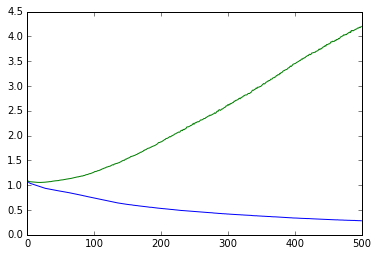

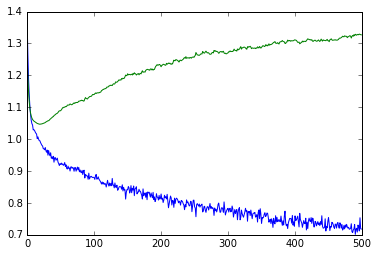

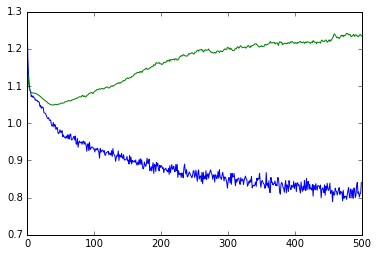

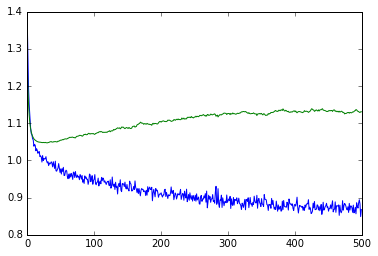

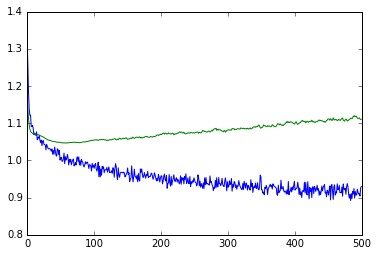

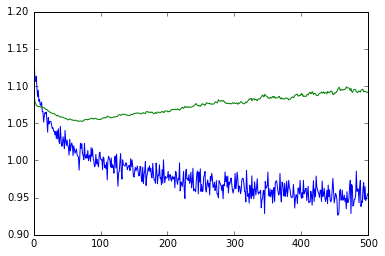

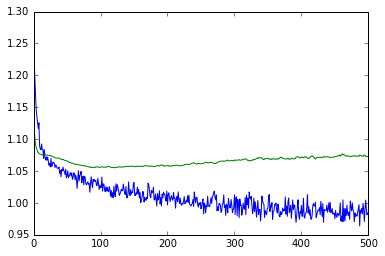

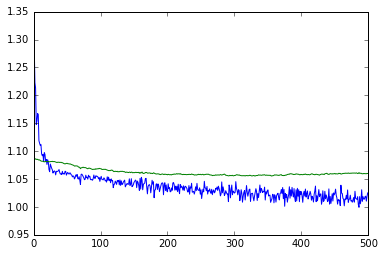

In [111]:
mins = dropoutTest()

[1.05411275695352,
 1.0468871453229118,
 1.0489633924820845,
 1.0472185050739962,
 1.0466017582837273,
 1.0525040907018326,
 1.054951176923864,
 1.055355478735531]

In [12]:
def kfoldTesting (X,y,s=g_best_size,dropout=g_best_dropout,kfold=5):
        s_val_loss=[]
        s_train_loss=[]
        for k in range(kfold):
            earlyCallback = EarlyStopping(patience=g_patience,verbose=1)
            model = createModel([s,s],dropout=dropout,input_dim=X.shape[1])
            history = model.fit(X,y,verbose=0,nb_epoch=g_epoch, validation_split=g_validation,show_accuracy=True,callbacks=[earlyCallback] )
            s_val_loss.append(history.history['val_loss'][-1])
            s_train_loss.append(history.history['loss'][-1])
        return s_train_loss,s_val_loss


In [13]:
def testNodeNum(X,y, sizes,dropout =0.4, kfold =5):
    #train_loss=[] 
    val_loss=[]
    train_loss=[]
    for s in sizes:
        s_train_loss,s_val_loss = kfoldTesting(X,y,s=s,dropout=dropout,kfold=kfold)
        print("size:{} , train:{} val_loss:{}".format(s,
                                np.mean(s_train_loss), np.mean(s_val_loss)))
        val_loss.append(s_val_loss)
        train_loss.append(s_train_loss)
    return train_loss,val_loss

In [181]:
sizes= range(45,55,1)
train_loss,val_loss= testNodeNum(X_scaled,y,sizes,dropout=g_best_dropout)

(1358, 138)
(1358, 3)


ValueError: Shape mismatch: x has 138 cols (and 128 rows) but y has 39 rows (and 45 cols)
Apply node that caused the error: Dot22(<TensorType(float32, matrix)>, <TensorType(float32, matrix)>)
Toposort index: 4
Inputs types: [TensorType(float32, matrix), TensorType(float32, matrix)]
Inputs shapes: [(128, 138), (39, 45)]
Inputs strides: [(552, 4), (180, 4)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Elemwise{Composite{scalar_sigmoid((i0 + i1))}}[(0, 0)](Dot22.0, InplaceDimShuffle{x,0}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

range(45, 55)


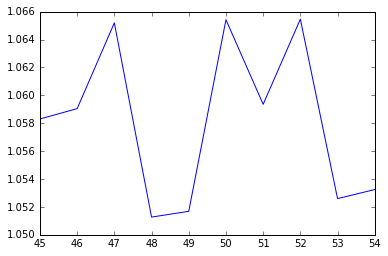

In [19]:
print(sizes)
plt.plot(sizes,np.mean(val_loss,axis=1))
plt.figure()

In [ ]:
def testDropoutRate(X,y, sizes,dropout):
    train_scores,scores,  proba_test,proba_y= crossValidate2(sizes,X,y,fold=5,dropout=dropout,earlyStopping=True)
    print("dropout:{} , val_loss_mean:{}".format(dropout,np.mean(scores)))
    return train_scores,scores

In [ ]:
g_dropout_range =np.arange(0.1,1, 0.1)
g_train_loss=[]
g_score_loss =[]
for d in g_dropout_range:
    train_loss, score_loss = testDropoutRate(X_scaled,y,[55,55],float(d))
    g_train_loss.append(train_loss)
    g_score_loss.append(score_loss)

In [ ]:
import matplotlib.pyplot as plt
g_train_mean = np.mean(g_score_loss,axis=1)
g_test_mean = np.mean(g_score_loss,axis=1)
g_test_std = np.std(g_score_loss,axis = 1)
plt.plot(g_dropout_range,g_test_mean)
plt.plot(g_dropout_range,g_train_mean,color='red')
plt.fill_between(g_dropout_range, g_test_mean - g_test_std, g_test_mean+g_test_std,alpha=0.3)
plt.figure()


In [14]:
def findRecordsByDf(self,df):
    #print((df['DayStamp']).values)
    #date = convertToDate((df['DayStamp']).values)
    #df["Date"] = date
    
    home = df['HomeTeam'].values
    away = df['AwayTeam'].values
    origin = self.df[["Date","HomeTeam","AwayTeam","JocH","JocD","JocA"]]
    origin["DayStamp"]=(pd.to_numeric(origin['Date'])/1e9/24/60/60).values
    origin["DayStamp"] = origin["DayStamp"].apply(lambda x: "%.f"%(float(x)))
    df['DayStamp']=df['DayStamp'].apply(lambda x: "%.f"%(float(x)))
    return origin.merge(df,left_on=['DayStamp',"HomeTeam","AwayTeam"],right_on=["DayStamp","HomeTeam","AwayTeam"],how='inner')
   
def mergeXWithOdds_Proba(self,X, y_proba, y_true):
    decoded = oneHotDecode(self, X)
    dates = X[:,c.dateColumn] 
    homeTeam = self.inverseTeamMapping(decoded[:,0])
    awayTeam =self.inverseTeamMapping(decoded[:,1])
    temp = np.vstack([homeTeam,awayTeam,dates]).T
    df = pd.DataFrame(np.hstack([temp,y_proba,y_true])
                      ,columns=["HomeTeam","AwayTeam","DayStamp","H_prob","D_prob","A_prob","H","D","A"])
    origin = self.df[["Date","HomeTeam","AwayTeam","JocH","JocD","JocA"]]
    origin["DayStamp"]=(pd.to_numeric(origin['Date'])/1e9/24/60/60).values
    origin["DayStamp"] = origin["DayStamp"].apply(lambda x: "%.f"%(float(x)))
    df['DayStamp']=df['DayStamp'].apply(lambda x: "%.f"%(float(x)))
    resultDf=  origin.merge(df,left_on=['DayStamp',"HomeTeam","AwayTeam"],right_on=["DayStamp","HomeTeam","AwayTeam"],how='inner')  
    return resultDf

In [197]:
withodds = findRecordsByDf(c,resultdf)

/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [27]:
import math
def formatMatrixs(oddDf , precisionDf):
    proba_mat = oddDf[['H_prob','D_prob','A_prob']].values
    def locatePrecision(proba_mat, precisionDf):
        precisionMat = precisionDf.values
        pre_cols=[4,7,10]
        def convert(proba, pre_col = 4):
            if proba < 0.2:
                return proba
            for i in range(precisionMat.shape[0]):
                if precisionMat[i,0] <= proba and proba < precisionMat[i,1] :
                    if math.isnan(precisionMat[i,pre_col]):
                        return proba
                    else:
                        return precisionMat[i,pre_col]
        h_fproba = np.array([ convert(float(proba)) for proba in proba_mat[:,0] ] )
        d_fproba = np.array([ convert(float(proba),pre_col=7) for proba in proba_mat[:,1] ] )
        a_fproba = np.array([ convert(float(proba),pre_col=10) for proba in proba_mat[:,2] ] )
        return h_fproba, d_fproba,a_fproba
    #h_fproba, d_fproba,a_fproba =locatePrecision(proba_mat,precisionDf)
    #fproba_mat = np.hstack([h_fproba,d_fproba,a_fproba]).reshape(3,h_fproba.shape[0]).T
    fproba_mat = proba_mat.astype('float')
    odd_mat = oddDf[['JocH','JocD','JocA']].values
    win_mat = None
    if 'H' in oddDf.columns:
        win_mat = oddDf[['H','D','A']].values
    return fproba_mat,odd_mat,win_mat

In [199]:
fproba_mat,odd_mat,win_mat= formatMatrixs(withodds,p_matrix)

In [16]:
def strategy1(fproba_mat,odd_mat,win_mat):
    exp = odd_mat * fproba_mat
    maxi = np.argmax(exp,axis=1)
    y_true = np.argmax(win_mat,axis=1)
    spent = 0
    expectation = 0
    income = 0
    for i in range(maxi.shape[0]):
        if exp[i,maxi[i]] > 1:
            expectation = expectation+ exp[i,maxi[i]]
            spent = spent+1
            if maxi[i] == y_true[i]:
                income = income + odd_mat[i,maxi[i]]
            
            
        
    print("Spent:{}, Income:{}, expectation:{}".format(spent,income,expectation))

In [ ]:
strategy1(fproba_mat,odd_mat,win_mat)

In [15]:
from datetime import date
def strategy4(fproba_mat,odd_mat,win_mat,info, z = 0.2 ,e =1.8 ):
    exp = odd_mat * fproba_mat
    y_true=None
    if win_mat is None:
        y_true = np.zeros(shape=(fproba_mat.shape[0],))
    else:
        y_true = np.argmax(win_mat,axis=1)
    spent = 0
    expectation = 0
    income = 0
    total = fproba_mat.shape[0]
    withdraw = 0
    buy = 0
    homeTeam = info["HomeTeam"].values
    awayTeam = info["AwayTeam"].values
    dates = [date(2015,1,1) for _ in range(homeTeam.shape[0])] 
    if "DayStamp" in info:
        dates = convertToDate(info["DayStamp"].values)
    receipt = []
    def chooseFrom(match, chosable):
        max_prob = -1
        c = 0
        for choice in chosable:
            if fproba_mat[match,choice] > max_prob:
                c = choice
                max_prob = fproba_mat[match,choice]
        return c
    for match in range(exp.shape[0]):
        chosable = []
        for choose in range(3):
            if exp[match,choose]> e and fproba_mat[match,choose] >= z:
                chosable.append(choose)
                
        if len(chosable) == 0:
            withdraw= withdraw+1
            continue
        choice = chooseFrom(match,chosable)
        expectation = expectation+ exp[match,choice]
        spent = spent+1
        buy =buy +1 
        receipt.append(np.hstack([dates[match],homeTeam[match],awayTeam[match], odd_mat[match,choice],choice,y_true[match],fproba_mat[match,:]]))
        if choice == y_true[match]:
            income = income + odd_mat[match,choice]
    #print(buy)
    #print("Spent:{}, Income:{}, expectation:{}, withdraw:{}(total:{})".
    #      format(spent,income,expectation,withdraw,total))
    receiptDf = pd.DataFrame(receipt,columns=["Date","home","away","odd of choice","choice","result","Hp","Dp","Ap"])
    return spent,income,expectation,withdraw,total,receiptDf

In [203]:
spent,income,expectation,withdraw,total,receipt = strategy4(fproba_mat,odd_mat,win_mat,withodds,z=0.2,e=1.6)

In [17]:
g_z_range = np.arange(0,1,0.05)
g_e_range = np.arange(1,2,0.05)
def range_strategy4_test(fproba_mat,odd_mat,win_mat,info):
    g_incomes = []
    g_spents =[]
    g_withdraws=[]
    g_exps=[]
    g_total = 0
    receipts=[]
    for e in g_e_range:
        for z in g_z_range:
            spent,income,expectation,withdraw,total,receipt = strategy4(fproba_mat,odd_mat,win_mat,info,z=z,e=e)
            g_spents.append(spent)
            g_incomes.append(income)
            g_withdraws.append(withdraw)
            g_exps.append(expectation)
            g_total= total
            receipts.append(receipt)
    return g_spents,g_incomes,g_exps,g_withdraws,g_total,receipts


In [129]:
g_node_sizes=[g_best_size,g_best_size]
X, y = c.getH7(removeInsufficient=True)
X_scaled = StandardScaler().fit_transform(X)

In [54]:
def getPrecisionMaxtrix(X,y,node_sizes):
    _,_, proba_test,proba_y,_ = crossValidate2(node_sizes,X,y,dropout=g_best_dropout,fold=10)
    p_matrix = precisionMatrix(np.vstack(proba_test),np.vstack(proba_y)) 
    return p_matrix

In [191]:
g_p_matrix= getPrecisionMaxtrix(X, y,g_node_sizes)

/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:223: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:231: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


start format
[['HS_Acc' 'HST_Acc' 'H_poss_Acc' 'H_atk_3rd_Acc' 'H_atk_3rd_tot_Acc'
  'H_red_goal_Acc' 'H_red_on_Acc' 'H_red_tot_Acc' 'H_chance_goal_Acc'
  'H_chance_tot_Acc' 'H_successful_tackle_Acc' 'H_tackle_tot_Acc'
  'H_successful_clearance_Acc' 'H_clearance_tot_Acc' 'H_interceptions_Acc'
  'H_blocks_Acc']
 ['AS_Acc' 'AST_Acc' 'A_poss_Acc' 'A_atk_3rd_Acc' 'A_atk_3rd_tot_Acc'
  'A_red_goal_Acc' 'A_red_on_Acc' 'A_red_tot_Acc' 'A_chance_goal_Acc'
  'A_chance_tot_Acc' 'A_successful_tackle_Acc' 'A_tackle_tot_Acc'
  'A_successful_clearance_Acc' 'A_clearance_tot_Acc' 'A_interceptions_Acc'
  'A_blocks_Acc']]
finish
Epoch 00030: early stopping
1221/1221 [==============================] - 0s     
Fold: 1, Class dist.: [539 298 384], val_loss: 1.015
Epoch 00031: early stopping
1221/1221 [==============================] - 0s     
Fold: 2, Class dist.: [539 298 384], val_loss: 0.990
Epoch 00035: early stopping
1222/1222 [==============================] - 0s     
Fold: 3, Class dist.: [539 299 3

In [192]:
g_p_matrix

,[lower,upper),h_Correct,h_Wrong,h_Precent,d_Correct,d_Wrong,d_Precent,a_Correct,a_Wrong,a_Precent
>80,0.8,1.0,37,13,0.740000,0,0,NaN,1,0,1.000000
60-80,0.6,0.8,209,114,0.647059,0,0,NaN,52,28,0.650000
50-60,0.5,0.6,84,87,0.491228,0,1,0.000000,86,69,0.554839
40-50,0.4,0.5,102,108,0.485714,3,12,0.200000,66,125,0.345550
30-40,0.3,0.4,64,123,0.342246,55,126,0.303867,75,148,0.336323
20-30,0.2,0.3,77,169,0.313008,213,626,0.253874,78,186,0.295455
<20,0.0,0.2,26,145,0.152047,61,261,0.189441,69,375,0.155405


In [18]:
def getTrainedModel(node_sizes,c):
    X, y = c.getH7(removeInsufficient=True)
    X_scaled = StandardScaler().fit_transform(X) 
    model = createModel(node_sizes,X_scaled.shape[1])
    earlyCallback = EarlyStopping(patience=g_patience,verbose=1)
    history = model.fit(X_scaled,y,verbose=0,nb_epoch=500, validation_split=0.1, callbacks=[earlyCallback])
    return model
    

In [135]:
g_model = getTrainedModel(g_node_sizes,c)

start format
[['HS_Acc' 'HST_Acc' 'H_poss_Acc' 'H_atk_3rd_Acc' 'H_atk_3rd_tot_Acc'
  'H_red_goal_Acc' 'H_red_on_Acc' 'H_red_tot_Acc' 'H_chance_goal_Acc'
  'H_chance_tot_Acc' 'H_successful_tackle_Acc' 'H_tackle_tot_Acc'
  'H_successful_clearance_Acc' 'H_clearance_tot_Acc' 'H_interceptions_Acc'
  'H_blocks_Acc']
 ['AS_Acc' 'AST_Acc' 'A_poss_Acc' 'A_atk_3rd_Acc' 'A_atk_3rd_tot_Acc'
  'A_red_goal_Acc' 'A_red_on_Acc' 'A_red_tot_Acc' 'A_chance_goal_Acc'
  'A_chance_tot_Acc' 'A_successful_tackle_Acc' 'A_tackle_tot_Acc'
  'A_successful_clearance_Acc' 'A_clearance_tot_Acc' 'A_interceptions_Acc'
  'A_blocks_Acc']]
finish
Epoch 00019: early stopping


/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:223: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:231: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [154]:
from sklearn.preprocessing import StandardScaler
def predictFuture(node_sizes,c,p_matrix,model):
    X_test,y_test = c.getH7(removeInsufficient = True,future=True)
    X_test_scaled = StandardScaler().fit_transform(X_test)
    proba_y = model.predict_proba(X_test_scaled)
   
    def getTestDf (X_test,proba_y,c):
        decoded = oneHotDecode(c, X_test)
        homeNames = c.inverseTeamMapping(decoded[:,0])
        awayNames = c.inverseTeamMapping(decoded[:,1])
        names = np.array([homeNames,awayNames]).T
        return pd.DataFrame(np.hstack([names,proba_y]),columns=['HomeTeam','AwayTeam','H_prob','D_prob','A_prob'])
   
    test_df = getTestDf(X_test,proba_y,c)
    test_df = test_df.sort(columns="HomeTeam")
    originDf = c.df[c.df["Future"]==1].sort(columns="HomeTeam")
    test_df['JocH']=originDf['JocH'].values
    test_df['JocD']=originDf['JocD'].values
    test_df['JocA']=originDf['JocA'].values
    fproba_mat,odd_mat,_= formatMatrixs(test_df,p_matrix)
    return fproba_mat,odd_mat,test_df
    
    

In [155]:
fproba_mat,odd_mat,test_df=predictFuture(g_node_sizes,c,g_p_matrix,g_model)

start format
[['HS_Acc' 'HST_Acc' 'H_poss_Acc' 'H_atk_3rd_Acc' 'H_atk_3rd_tot_Acc'
  'H_red_goal_Acc' 'H_red_on_Acc' 'H_red_tot_Acc' 'H_chance_goal_Acc'
  'H_chance_tot_Acc' 'H_successful_tackle_Acc' 'H_tackle_tot_Acc'
  'H_successful_clearance_Acc' 'H_clearance_tot_Acc' 'H_interceptions_Acc'
  'H_blocks_Acc']
 ['AS_Acc' 'AST_Acc' 'A_poss_Acc' 'A_atk_3rd_Acc' 'A_atk_3rd_tot_Acc'
  'A_red_goal_Acc' 'A_red_on_Acc' 'A_red_tot_Acc' 'A_chance_goal_Acc'
  'A_chance_tot_Acc' 'A_successful_tackle_Acc' 'A_tackle_tot_Acc'
  'A_successful_clearance_Acc' 'A_clearance_tot_Acc' 'A_interceptions_Acc'
  'A_blocks_Acc']]
finish
9/9 [==============================] - 0s

/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:223: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:231: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [164]:
spent,income,expectation,withdraw,total,receipt = strategy4(fproba_mat,odd_mat,None,test_df,z=0.2,e=1.6)

In [165]:
receipt

,home,away,odd of choice,choice,result,Hp,Dp,Ap


In [ ]:
c.df[["Date","HomeTeam","AwayTeam"]].sort(columns ="Date",ascending = False)


In [170]:
from sklearn.ensemble import RandomForestClassifier

In [185]:
forest =RandomForestClassifier(n_estimators = 10000)

In [186]:
forest.fit(X_scaled,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [187]:
    X_test,y_test = c.getH7(removeInsufficient = True,future=True)
    X_test_scaled = StandardScaler().fit_transform(X_test)

start format
[['HS_Acc' 'HST_Acc' 'H_poss_Acc' 'H_atk_3rd_Acc' 'H_atk_3rd_tot_Acc'
  'H_red_goal_Acc' 'H_red_on_Acc' 'H_red_tot_Acc' 'H_chance_goal_Acc'
  'H_chance_tot_Acc' 'H_successful_tackle_Acc' 'H_tackle_tot_Acc'
  'H_successful_clearance_Acc' 'H_clearance_tot_Acc' 'H_interceptions_Acc'
  'H_blocks_Acc']
 ['AS_Acc' 'AST_Acc' 'A_poss_Acc' 'A_atk_3rd_Acc' 'A_atk_3rd_tot_Acc'
  'A_red_goal_Acc' 'A_red_on_Acc' 'A_red_tot_Acc' 'A_chance_goal_Acc'
  'A_chance_tot_Acc' 'A_successful_tackle_Acc' 'A_tackle_tot_Acc'
  'A_successful_clearance_Acc' 'A_clearance_tot_Acc' 'A_interceptions_Acc'
  'A_blocks_Acc']]
finish


/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:223: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:231: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [188]:
result =np.array(forest.predict_proba(X_test))

array([[ 0.4075,  0.3284,  0.2641],
       [ 0.3526,  0.3407,  0.3067],
       [ 0.3954,  0.3455,  0.2591],
       [ 0.3978,  0.3391,  0.2631],
       [ 0.403 ,  0.3453,  0.2517],
       [ 0.3905,  0.3458,  0.2637],
       [ 0.4031,  0.3336,  0.2633],
       [ 0.3597,  0.3373,  0.303 ],
       [ 0.4072,  0.3307,  0.2621]])

In [52]:
g_X,g_y = c.getH7()

start format
[['HS_Acc' 'HST_Acc' 'H_poss_Acc' 'H_atk_3rd_Acc' 'H_atk_3rd_tot_Acc'
  'H_red_goal_Acc' 'H_red_on_Acc' 'H_red_tot_Acc' 'H_chance_goal_Acc'
  'H_chance_tot_Acc' 'H_successful_tackle_Acc' 'H_tackle_tot_Acc'
  'H_successful_clearance_Acc' 'H_clearance_tot_Acc' 'H_interceptions_Acc'
  'H_blocks_Acc']
 ['AS_Acc' 'AST_Acc' 'A_poss_Acc' 'A_atk_3rd_Acc' 'A_atk_3rd_tot_Acc'
  'A_red_goal_Acc' 'A_red_on_Acc' 'A_red_tot_Acc' 'A_chance_goal_Acc'
  'A_chance_tot_Acc' 'A_successful_tackle_Acc' 'A_tackle_tot_Acc'
  'A_successful_clearance_Acc' 'A_clearance_tot_Acc' 'A_interceptions_Acc'
  'A_blocks_Acc']]
finish


/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:223: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:231: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [53]:
g_X_train , g_X_test, g_y_train,g_y_test = splitData(g_X,g_y,test_size =0.2)

In [54]:
scaler = StandardScaler()
g_X_train_scaled = scaler.fit_transform(g_X_train)
g_X_test_scaled = scaler.transform(g_X_test)

In [19]:
from sklearn.lda import LDA
def getLda(X_train,y_train):
    lda = LDA(solver ='eigen',shrinkage='auto')
    lda.fit(X_train,np.argmax(y_train,axis=1))
    return lda


/home/y/scikit-learn/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


In [56]:
lda = getLda(g_X_train_scaled,g_y_train)
g_X_train_lda = lda.transform(g_X_train_scaled)
g_y_arg = np.argmax(g_y_train,axis=1)


In [57]:
def transform_train_test_set(X_train,X_test,y_train,y_test, retain = None):
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    lda = getLda(X_train_std,y_train)
    if retain is None:
        X_train_best = lda.transform(X_train_std)
        X_test_best = lda.transform(X_test_std)
        return X_train_best,X_test_best
    else:
        X_train_best = lda.transform(X_train_std)[:,0:retain]
        X_test_best = lda.transform(X_test_std)[:,0:retain]
        return X_train_best,X_test_best
    
def get_train_test_set():
    X,y = c.getH7()
    X_train,X_test,y_train, y_test = splitData(X,y,test_size=0.2)
    X_train_lda,X_test_lda = transform_train_test_set(X_train,X_test,y_train,y_test)
    return X_train_lda,X_test_lda,y_train,y_test,X_test
    

In [43]:
g_X_train_lda , g_X_test_lda, g_y_train , g_y_test, g_X_test  = get_train_test_set()

start format
[['HS_Acc' 'HST_Acc' 'H_poss_Acc' 'H_atk_3rd_Acc' 'H_atk_3rd_tot_Acc'
  'H_red_goal_Acc' 'H_red_on_Acc' 'H_red_tot_Acc' 'H_chance_goal_Acc'
  'H_chance_tot_Acc' 'H_successful_tackle_Acc' 'H_tackle_tot_Acc'
  'H_successful_clearance_Acc' 'H_clearance_tot_Acc' 'H_interceptions_Acc'
  'H_blocks_Acc']
 ['AS_Acc' 'AST_Acc' 'A_poss_Acc' 'A_atk_3rd_Acc' 'A_atk_3rd_tot_Acc'
  'A_red_goal_Acc' 'A_red_on_Acc' 'A_red_tot_Acc' 'A_chance_goal_Acc'
  'A_chance_tot_Acc' 'A_successful_tackle_Acc' 'A_tackle_tot_Acc'
  'A_successful_clearance_Acc' 'A_clearance_tot_Acc' 'A_interceptions_Acc'
  'A_blocks_Acc']]
finish


/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:223: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:231: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


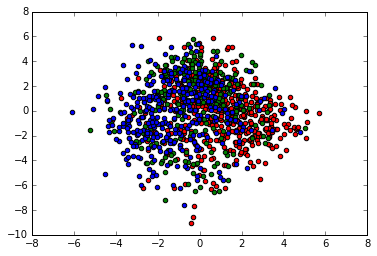

In [45]:
g_colors = ['r','g','b']
g_y_arg = np.argmax(g_y_train,axis=1)
for i in range (3):
    tempX = g_X_train_lda[g_y_arg==i,:]
    plt.scatter(tempX[:,0],tempX[:,1],c = g_colors[i])
plt.figure()

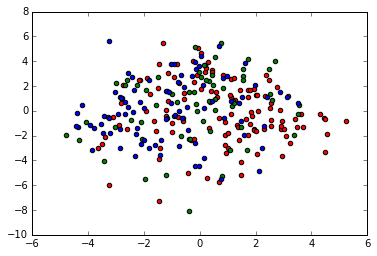

In [47]:
g_colors = ['r','g','b']
g_y_test_arg = np.argmax(g_y_test,axis=1)
for i in range (3):
    tempX = g_X_test_lda[g_y_test_arg==i,:]
    plt.scatter(tempX[:,0],tempX[:,1],c = g_colors[i])
plt.figure()

In [32]:
def testRetainNum(X_train_lda, y_train,variance_ratio, threshold = 0.001):
    maxChoose = variance_ratio[variance_ratio >threshold].shape[0]
    print("maxChoose {}".format(maxChoose))
    losses = []
    val_losses = []
    print(X_train_lda.shape)
    print(y_train.shape)
    dim_range =range(2, maxChoose+1,2)
    for i in dim_range:
        train_loss , val_loss = kfoldTesting(X_train_lda[:,0:i],y_train,s=i)
        print("dim{}: train {}, val {}".format(i,np.mean(train_loss),np.mean(val_loss)))
        losses.append(train_loss)
        val_losses.append(val_loss)
    return losses, val_losses,dim_range
    

In [28]:
eigen_losses ,eigen_val_losses,dim_range = testRetainNum(g_X_train_lda,g_y_train,lda.explained_variance_ratio_)

maxChoose 68
(1086, 138)
(1086, 3)
Epoch 00082: early stopping
Epoch 00092: early stopping
Epoch 00100: early stopping
Epoch 00115: early stopping
Epoch 00099: early stopping
dim2: train 0.9972330941029204, val 0.989859585201039
Epoch 00068: early stopping
Epoch 00094: early stopping
Epoch 00079: early stopping
Epoch 00097: early stopping
Epoch 00095: early stopping
dim4: train 0.9741176704516867, val 0.9788437170140882
Epoch 00076: early stopping
Epoch 00055: early stopping
Epoch 00082: early stopping
Epoch 00100: early stopping
Epoch 00077: early stopping
dim6: train 0.9564871733545963, val 0.9735073117648854
Epoch 00057: early stopping
Epoch 00061: early stopping
Epoch 00050: early stopping
Epoch 00074: early stopping
Epoch 00064: early stopping
dim8: train 0.9509325670668769, val 0.9680630389381857
Epoch 00064: early stopping
Epoch 00080: early stopping
Epoch 00072: early stopping
Epoch 00071: early stopping
Epoch 00052: early stopping
dim10: train 0.9465029346562135, val 0.9641666

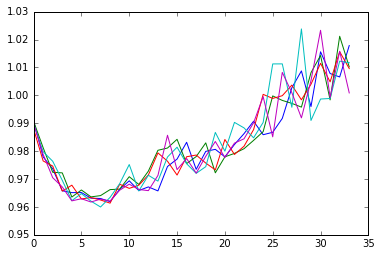

In [31]:
plt.plot(eigen_val_losses)

In [24]:
def svdTest(X,y):
    lda = LDA(solver ='svd')
    X_lda = lda.fit_transform(X,np.argmax(y,axis=1))
    train_loss , val_loss = kfoldTesting(X_lda,y,s=X_lda.shape[1])
    return train_loss, val_loss

In [25]:
train_loss, val_loss = svdTest(g_X_train_scaled,g_y_train)

Epoch 00134: early stopping
Epoch 00113: early stopping
Epoch 00113: early stopping
Epoch 00109: early stopping
Epoch 00107: early stopping


/home/y/scikit-learn/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [46]:
g_input_dim = 16
g_best_size = g_input_dim

In [47]:
g_X_train_best = g_X_train_lda[:,0:g_input_dim]
g_X_test_best = g_X_test_lda[:,0:g_input_dim]

In [68]:
g_p_matrix= getPrecisionMaxtrix(g_X_train_best, g_y_train,[g_input_dim,g_input_dim])
g_p_matrix

Epoch 00056: early stopping
976/976 [==============================] - 0s     
Fold: 1, Class dist.: [422 239 315], test_loss: 0.917
Epoch 00085: early stopping
977/977 [==============================] - 0s     
Fold: 2, Class dist.: [422 239 316], test_loss: 0.951
Epoch 00056: early stopping
977/977 [==============================] - 0s     
Fold: 3, Class dist.: [422 239 316], test_loss: 0.982
Epoch 00065: early stopping
977/977 [==============================] - 0s     
Fold: 4, Class dist.: [422 239 316], test_loss: 1.002
Epoch 00051: early stopping
977/977 [==============================] - 0s     
Fold: 5, Class dist.: [422 239 316], test_loss: 0.974
Epoch 00067: early stopping
977/977 [==============================] - 0s     
Fold: 6, Class dist.: [422 239 316], test_loss: 0.872
Epoch 00088: early stopping
978/978 [==============================] - 0s     
Fold: 7, Class dist.: [422 240 316], test_loss: 0.973
Epoch 00083: early stopping
978/978 [==============================] 

,[lower,upper),h_Correct,h_Wrong,h_Precent,d_Correct,d_Wrong,d_Precent,a_Correct,a_Wrong,a_Precent
>80,0.8,1.0,3,2,0.600000,0,0,NaN,0,0,NaN
60-80,0.6,0.8,231,104,0.689552,0,0,NaN,66,27,0.709677
50-60,0.5,0.6,65,62,0.511811,0,0,NaN,86,47,0.646617
40-50,0.4,0.5,57,94,0.377483,12,10,0.545455,43,85,0.335938
30-40,0.3,0.4,54,87,0.382979,74,120,0.381443,46,96,0.323944
20-30,0.2,0.3,45,150,0.230769,109,346,0.239560,49,131,0.272222
<20,0.0,0.2,14,118,0.106061,71,344,0.171084,61,349,0.148780


In [76]:
g_p_matrix

,[lower,upper),h_Correct,h_Wrong,h_Precent,d_Correct,d_Wrong,d_Precent,a_Correct,a_Wrong,a_Precent
>80,0.8,1.0,47,12,0.796610,0,0,NaN,0,0,NaN
60-80,0.6,0.8,207,88,0.701695,0,0,NaN,38,8,0.826087
50-60,0.5,0.6,54,62,0.465517,1,1,0.500000,67,56,0.544715
40-50,0.4,0.5,61,77,0.442029,29,29,0.500000,71,78,0.476510
30-40,0.3,0.4,60,93,0.392157,75,139,0.350467,60,125,0.324324
20-30,0.2,0.3,52,184,0.220339,77,236,0.246006,50,144,0.257732
<20,0.0,0.2,11,78,0.123596,76,423,0.152305,50,339,0.128535


In [52]:
def betTesting(X_train,X_test, y_train,y_test,origin_X_test, p_matrix):
    model = createModel([g_best_size,g_best_size],input_dim=X_train.shape[1])
    earlyCallback = EarlyStopping(patience=g_patience,verbose=1)
    history = model.fit(X_train,y_train,verbose=0,nb_epoch=g_epoch, validation_split=g_validation,show_accuracy=True,callbacks=[earlyCallback] )
    y_proba = model.predict_proba(X_test)
    odds_proba_df = mergeXWithOdds_Proba(c,origin_X_test,y_proba,y_test)
    fproba_mat,odd_mat,win_mat= formatMatrixs(odds_proba_df,p_matrix)
    print(odd_mat.dtype)
    print(fproba_mat.dtype)
    print(odd_mat*fproba_mat)
    #changed
    spent,income,expectation,withdraw,total,receipt = range_strategy4_test(fproba_mat,odd_mat,win_mat,odds_proba_df)
    return spent,income,expectation,withdraw,total,receipt
def kfoldBetTest(kfold = 10 ,input_dim = g_input_dim):
    spents= []
    incomes =[]
    exps = []
    withs =[]
    totals, receipts,p_matrixs =[],[],[]
    for k in range(kfold):
        print("fold {}".format(k))
        X_train_lda,X_test_lda,y_train,y_test,X_test = get_train_test_set()
        X_train_best = X_train_lda[:,0:input_dim]
        X_test_best = X_test_lda[:,0:input_dim]
        p_matrix= getPrecisionMaxtrix(X_train_best, y_train,[input_dim,input_dim])
        spent,income,expectation,withdraw,total,receipt = betTesting(X_train_best,X_test_best,y_train,y_test,X_test,None)
        spents.append(spent)
        incomes.append(income)
        exps.append(expectation)
        withs.append(withdraw)
        totals.append(totals)
        receipts.append(receipt)
        #p_matrixs.append(p_matrix)
        clear_output()
    print("finish")
    return spents, incomes, exps, withs , totals, receipts,p_matrixs 
    


In [55]:
spents, incomes, exps, withs , totals, receipts,p_matrixs = kfoldBetTest(kfold=10)

fold 0
start format
[['HS_Acc' 'HST_Acc' 'H_poss_Acc' 'H_atk_3rd_Acc' 'H_atk_3rd_tot_Acc'
  'H_red_goal_Acc' 'H_red_on_Acc' 'H_red_tot_Acc' 'H_chance_goal_Acc'
  'H_chance_tot_Acc' 'H_successful_tackle_Acc' 'H_tackle_tot_Acc'
  'H_successful_clearance_Acc' 'H_clearance_tot_Acc' 'H_interceptions_Acc'
  'H_blocks_Acc']
 ['AS_Acc' 'AST_Acc' 'A_poss_Acc' 'A_atk_3rd_Acc' 'A_atk_3rd_tot_Acc'
  'A_red_goal_Acc' 'A_red_on_Acc' 'A_red_tot_Acc' 'A_chance_goal_Acc'
  'A_chance_tot_Acc' 'A_successful_tackle_Acc' 'A_tackle_tot_Acc'
  'A_successful_clearance_Acc' 'A_clearance_tot_Acc' 'A_interceptions_Acc'
  'A_blocks_Acc']]
finish
Epoch 00051: early stopping
976/976 [==============================] - 0s     
Fold: 1, Class dist.: [433 233 310], test_loss: 0.926
Epoch 00046: early stopping
976/976 [==============================] - 0s     
Fold: 2, Class dist.: [433 233 310], test_loss: 1.001
Epoch 00046: early stopping
977/977 [==============================] - 0s     
Fold: 3, Class dist.: [434 23

/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:223: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:231: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


KeyboardInterrupt: 

In [50]:
n_spents = np.array(spents).reshape(10,len(g_e_range),len(g_z_range))
n_incomes = np.array(incomes).reshape(10,len(g_e_range),len(g_z_range))
n_incomes_min = np.min(n_incomes,axis=0)
n_spents_max = np.max(n_spents,axis=0)
n_nets = n_incomes - n_spents

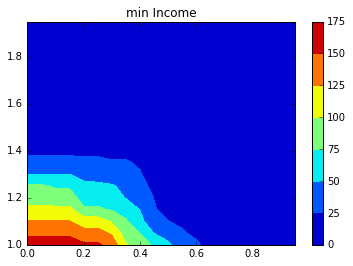

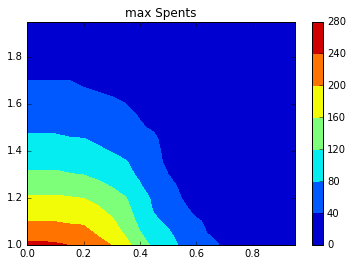

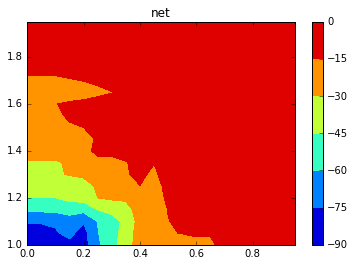

In [51]:
g_Z, g_E =np.meshgrid(g_z_range,g_e_range)
CS =  plt.contourf(g_Z,g_E,n_incomes_min)
plt.title("min Income")
cbar = plt.colorbar(CS)
plt.figure() 
CS = plt.contourf(g_Z,g_E,n_spents_max)
plt.title("max Spents")
cbar = plt.colorbar(CS)
plt.figure()
CS = plt.contourf(g_Z,g_E,np.min(n_nets,axis=0))
plt.title("net")
cbar = plt.colorbar(CS)
plt.figure()

In [66]:

def futureTest3(node_sizes, X,y, ori_dates, numOfWeek = 10,verbose=False):
    dates = convertToDate(ori_dates)
    dates = [d - timedelta(days=2) for d in dates]    
    weeks  = [ v.isocalendar()[1] for v in dates]
    thisWeek = weeks[-1]
    start = -1
    last = X.shape[0]
    index = -1
    w = 0
    sum_proba =None 
    sum_y =None
    sum_train_proba=None
    sum_train_y=None
    results = None
    while w < numOfWeek:
        if thisWeek != weeks[index]:
            print("week{}".format(w))
            start = X.shape[0] +index+1
            X_train = X[0:start, :]
            X_test = X[start:last,:]
            y_train = y[0:start,:]
            y_test = y[start:last,:]
            #transform
            X_train_best,X_test_best = transform_train_test_set(X_train,X_test,y_train,y_test,retain=g_input_dim)
            #
            earlyCallback = EarlyStopping(patience=g_patience,verbose=1)
            model = createModel(node_sizes,input_dim=X_train_best.shape[1],dropout=g_best_dropout)
            history = model.fit(X_train_best,y_train,verbose=0,nb_epoch=g_epoch, validation_split=g_validation, callbacks=[earlyCallback])
            decoded = oneHotDecode(c,X_test)
            home = np.array([c.inverseTeamMapping(decoded[:,0])]).reshape(X_test.shape[0],1)
            away = np.array([c.inverseTeamMapping(decoded[:,1])]).reshape(X_test.shape[0],1)
            stack = np.hstack([home,away])
            proba = model.predict_proba(X_test_best)
            train_proba =model.predict_proba(X_train_best)
            errorIndx = np.argmax(proba,axis=1) != np.argmax(y_test,axis=1)
            tresult = np.hstack([np.array([w for i in range(proba.shape[0])]).reshape(proba.shape[0],1),
                                 ori_dates[start:last].reshape(proba.shape[0],1),stack,proba,y_test])
            if sum_proba is None:
                sum_proba = proba
                sum_y = y_test
                sum_train_proba = train_proba
                sum_train_y = y_train
                results =    tresult
            else:
                sum_proba = np.vstack([sum_proba,proba])
                sum_y = np.vstack([sum_y,y_test])
                sum_train_proba = np.vstack([sum_train_proba, train_proba])
                sum_train_y= np.vstack([sum_train_y, y_train])
                results =  np.vstack([results, tresult])
            if verbose == True:
                print("numOftest {} , loss {}".format(X_test.shape[0],model.evaluate(X_test,y_test)))               
                print (tresult)
                print("first2 : {}",firstNScore(2,proba,y_test))
            last = start
            thisWeek = weeks[index]
            w = w+1
        index = index -1
    start = X.shape[0] +index+1
    print("start compute precision_mat")
    X_train,X_useless, y_train,y_useless = X[0:start,:], X,y[0:start,:],y
    X_train_best,X_test_best = transform_train_test_set(X_train,X_test,y_train,y_test,retain=g_input_dim)
    _,_, proba_test,proba_y,_ = crossValidate2(node_sizes,X_train_best,y_train,fold=10,dropout=g_best_dropout)
    p_matrix = precisionMatrix(np.vstack(proba_test),np.vstack(proba_y))
    print("summary")
    print("score:")
    score = firstNScore(1,sum_proba,sum_y)
    print(score)
    print("2like")
    like2 = firstNScore(2,sum_proba,sum_y)
    print(precisionMatrix(sum_proba,sum_y))
    y_true= np.argmax(sum_y,axis=1)
    y_pred = np.argmax(sum_proba,axis=1)
    print("sum precision:{}".format(precision_score(y_true,y_pred,average=None)))
    resultdf= pd.DataFrame(results, columns=['week','DayStamp','HomeTeam','AwayTeam','H_prob','D_prob','A_prob','H','D','A'])
    return sum_proba, sum_y,resultdf,p_matrix

In [67]:
X,y = c.getH7()
sum_proba, sum_y,resultdf,p_matrix= futureTest3([g_best_size,g_best_size],X,y,X[:,c.dateColumn],numOfWeek=25,verbose=False)

start format
[['HS_Acc' 'HST_Acc' 'H_poss_Acc' 'H_atk_3rd_Acc' 'H_atk_3rd_tot_Acc'
  'H_red_goal_Acc' 'H_red_on_Acc' 'H_red_tot_Acc' 'H_chance_goal_Acc'
  'H_chance_tot_Acc' 'H_successful_tackle_Acc' 'H_tackle_tot_Acc'
  'H_successful_clearance_Acc' 'H_clearance_tot_Acc' 'H_interceptions_Acc'
  'H_blocks_Acc']
 ['AS_Acc' 'AST_Acc' 'A_poss_Acc' 'A_atk_3rd_Acc' 'A_atk_3rd_tot_Acc'
  'A_red_goal_Acc' 'A_red_on_Acc' 'A_red_tot_Acc' 'A_chance_goal_Acc'
  'A_chance_tot_Acc' 'A_successful_tackle_Acc' 'A_tackle_tot_Acc'
  'A_successful_clearance_Acc' 'A_clearance_tot_Acc' 'A_interceptions_Acc'
  'A_blocks_Acc']]

/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:223: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:231: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



finish
week0
Epoch 00051: early stopping
1348/1348 [==============================] - 0s     
week1
Epoch 00058: early stopping
1343/1343 [==============================] - 0s     
week2
Epoch 00062: early stopping
1328/1328 [==============================] - 0s     
week3
Epoch 00068: early stopping
1315/1315 [==============================] - 0s     
week4
Epoch 00062: early stopping
1305/1305 [==============================] - 0s     
week5
Epoch 00048: early stopping
1293/1293 [==============================] - 0s     
week6
Epoch 00054: early stopping
1285/1285 [==============================] - 0s     
week7
Epoch 00064: early stopping
1275/1275 [==============================] - 0s     
week8
Epoch 00049: early stopping
1258/1258 [==============================] - 0s     
week9
Epoch 00053: early stopping
1255/1255 [==============================] - 0s     
week10
Epoch 00073: early stopping
1244/1244 [==============================] - 0s     
week11
Epoch 00044: early stopping

In [68]:
withodds = findRecordsByDf(c,resultdf)
fproba_mat,odd_mat,win_mat= formatMatrixs(withodds,p_matrix)
g_spents,g_incomes,g_exps,g_withdraws,total,receipt = range_strategy4_test(fproba_mat,odd_mat,win_mat,withodds)


/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


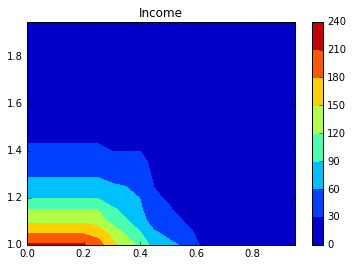

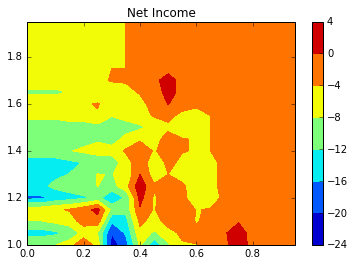

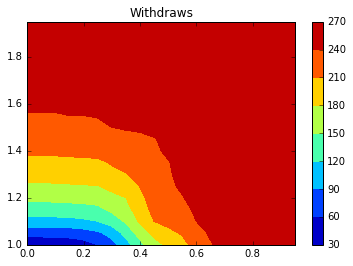

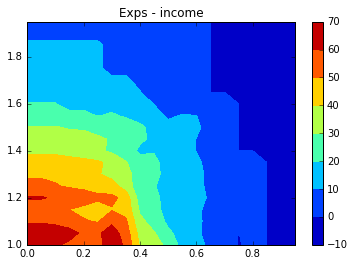

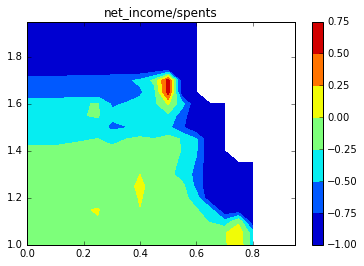

In [69]:
import matplotlib.pyplot as plt
g_n_incomes = np.array(g_incomes).reshape(len(g_e_range),len(g_z_range))
g_n_spent = np.array(g_spents).reshape(len(g_e_range),len(g_z_range))
g_n_withdraws = np.array(g_withdraws).reshape(len(g_e_range),len(g_z_range))
g_n_exps = np.array(g_exps).reshape(len(g_e_range),len(g_z_range))
Z, E =np.meshgrid(g_z_range,g_e_range)
CS = plt.contour = plt.contourf(Z,E,g_n_incomes)
plt.title("Income")
cbar = plt.colorbar(CS)
plt.figure()
CS = plt.contour = plt.contourf(Z,E,g_n_incomes-g_n_spent)
plt.title("Net Income")
cbar = plt.colorbar(CS)
plt.figure()
CS = plt.contour = plt.contourf(Z,E,g_n_withdraws)
plt.title("Withdraws")
cbar = plt.colorbar(CS)
plt.figure()
CS = plt.contour = plt.contourf(Z,E,g_n_exps - g_n_incomes)
plt.title("Exps - income")
cbar = plt.colorbar(CS)
plt.figure()
CS = plt.contour = plt.contourf(Z,E, (g_n_incomes-g_n_spent)/g_n_spent)
plt.title("net_income/spents")
cbar = plt.colorbar(CS)
plt.figure()

400

In [94]:
spent,income,expectation,withdraw,total,receipt = betTesting(g_X_train_best,g_X_test_best,g_y_train,g_y_test,g_X_test,g_p_matrix)

Epoch 00078: early stopping
272/272 [==============================] - 0s     

/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[[ 0.18005215  0.31303605  0.50691181]
 [ 0.31054801  0.28060815  0.40884382]
 [ 0.16130655  0.19486567  0.6438278 ]]
   HomeTeam  AwayTeam DayStamp               H_prob               D_prob  \
0   Norwich   Everton  16781.0  0.18005214631557465   0.3130360543727875   
1   Burnley     Stoke  16571.0  0.31054800748825073   0.2806081473827362   
2  West Ham  Man City  16368.0  0.16130654513835907  0.19486567378044128   

               A_prob      H      D      A  
0  0.5069118142127991  False   True  False  
1  0.4088438153266907  False   True  False  
2  0.6438277959823608   True  False  False  
[[False  True False]
 [False  True False]
 [ True False False]]


In [99]:
withodds = findRecordsByDf(c,resultdf)

,Date,home,away,odd of choice,choice,result,Hp,Dp,Ap
0,2016-03-20 08:00:00,Man City,Man United,3.50,1,2,0.511811,0.381443,0.153706
1,2016-03-19 08:00:00,Swansea,Aston Villa,5.35,2,0,0.377483,0.239560,0.272222
2,2016-03-19 08:00:00,Crystal Palace,Leicester,2.27,2,2,0.161898,0.239560,0.709677
3,2016-03-12 08:00:00,Norwich,Man City,5.50,0,1,0.230769,0.239560,0.646617
4,2016-03-12 08:00:00,Bournemouth,Swansea,4.15,2,0,0.511811,0.239560,0.272222
5,2016-03-12 08:00:00,Stoke,Southampton,2.50,0,2,0.689552,0.188027,0.158971
6,2016-03-05 08:00:00,Swansea,Norwich,1.80,0,0,0.689552,0.179772,0.126909
7,2016-03-05 08:00:00,Newcastle,Bournemouth,3.20,1,2,0.382979,0.545455,0.272222
8,2016-03-02 08:00:00,West Ham,Tottenham,1.85,2,0,0.165623,0.239560,0.646617
9,2016-03-02 08:00:00,Liverpool,Man City,3.20,1,0,0.230769,0.381443,0.335938


In [103]:
spent

240

In [104]:
income

330.96999999999997

In [105]:
expectation

321.91800103980205

In [106]:
receipt

,Date,home,away,odd of choice,choice,result,Hp,Dp,Ap
0,2016-03-19 08:00:00,Swansea,Aston Villa,3.60,1,0,0.442029,0.350467,0.257732
1,2016-03-13 08:00:00,Aston Villa,Tottenham,4.20,1,1,0.149121,0.246006,0.544715
2,2016-03-05 08:00:00,Newcastle,Bournemouth,3.20,1,2,0.220339,0.500000,0.257732
3,2016-03-05 08:00:00,Southampton,Sunderland,5.60,2,0,0.442029,0.246006,0.324324
4,2016-03-02 08:00:00,Stoke,Newcastle,3.25,1,0,0.392157,0.350467,0.324324
5,2016-03-01 08:00:00,Bournemouth,Southampton,2.43,2,2,0.392157,0.246006,0.476510
6,2016-02-27 08:00:00,Southampton,Chelsea,2.45,2,0,0.392157,0.175471,0.476510
7,2016-02-13 08:00:00,Chelsea,Newcastle,4.40,1,0,0.701695,0.246006,0.168387
8,2016-02-03 08:00:00,Everton,Newcastle,4.70,2,2,0.465517,0.177459,0.257732
9,2016-01-23 08:00:00,West Ham,Man City,4.90,0,0,0.220339,0.246006,0.476510
